In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hevc_decode_mu
import tqdm
plt.style.use('seaborn-whitegrid')

In [2]:
mu = hevc_decode_mu.mu()
mu #fps

113.06364141578675

In [3]:
target = 100  # [ms] The target sojourn time 

In [4]:
target_prob = 0.9999  # The reliability, 99.99% of all jobs should finish withing the target sojourn time 5G-Americas infrastructure-assisted perception

In [5]:
highway_lambdas = pd.read_csv('roads-lambdas/highway-corso-unita-italia-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
industrial_lambdas = pd.read_csv('roads-lambdas/industrial-corso-agneli.json-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
lowemission_lambdas = pd.read_csv('roads-lambdas/low-emissions-corso-san-maurizio-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
residential_lambdas = pd.read_csv('roads-lambdas/residential-corso-unione-sovietica-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')

# Look for the best approximation for every $(R,\rho)$

In [6]:
# README: Use the most up-to-date one
data = pd.read_csv('sweep_summary.csv')


def find_best(row):
    A = row['error A']
    B = row['error B']
    C = row['error C']
    D = row['error D']
    E = row['error E']
    F = row['error F']
    if A == min([A, B, C, D, E, F]):
        return 1
    if B == min([A, B, C, D, E, F]):
        return 2
    if C == min([A, B, C, D, E, F]):
        return 3
    if D == min([A, B, C, D, E, F]):
        return 4
    if E == min([A, B, C, D, E, F]):
        return 5
    if F == min([A, B, C, D, E, F]):
        return 6

# Here we obtain the best approx
data['best'] = data.apply(lambda row: find_best(row), axis=1)

In [7]:
data[['R', 'rho', 'best']].head(4)

R   rho  best
0  1  0.01     5
1  1  0.02     5
2  1  0.03     5
3  1  0.04     5

In [8]:
# Here we store the best approx. for every (R,rho) pair
cdfs = {}

# Derived from experiments parameters
infty = 130
mc_limits = { # R: mc_limit
    1: 22, 2:22, 3:22,
    4: 13, 5:7, 6:5, 7:4,
    8:3, 9:3, 10:2
}

for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in np.linspace(0.01, 0.99, 99):
        rho_r = round(rho, 2)
        method_idx = data[(data['R']==R) & (data['rho']==rho_r)]['best'].values[0]
        best_method = ['A','B','C','D','E','F'][method_idx-1]
        file = f'sweep/method{best_method}/mc_limit={mc_limits[R]}-infty={infty}-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        cdfs[(R, round(rho, 2))] = cdf

# Load Ciw CDFs using uniform, exp, & det service times

In [9]:
# CDFs for each service time distribution
exp_cdfs = {}
det_cdfs = {}
unif_cdfs = {}


for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in np.linspace(0.01, 0.99, 99):
        rho_r = round(rho, 2)
        
        # Exp
        file = f'sweep-expon/expon-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        exp_cdfs[(R, round(rho, 2))] = cdf
        
        # Det
        file = f'sweep-deterministic/deterministic-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        det_cdfs[(R, round(rho, 2))] = cdf
        
        # Unif
        file = f'sweep-uniform/uniform-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        unif_cdfs[(R, round(rho, 2))] = cdf

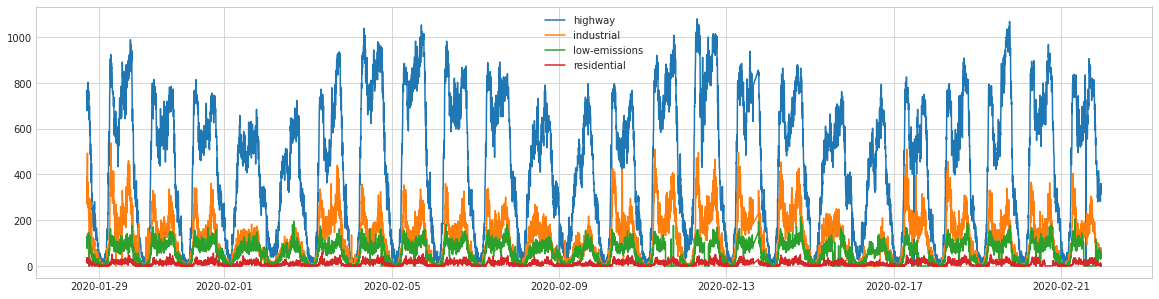

In [10]:
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(highway_lambdas['lambda_v2x'], label='highway')
ax.plot(industrial_lambdas['lambda_v2x'], label='industrial')
ax.plot(lowemission_lambdas['lambda_v2x'], label='low-emissions')
ax.plot(residential_lambdas['lambda_v2x'], label='residential')
plt.legend()
plt.show()

In [10]:
def get_percentiles(lmbda, mu, R, p, cdfs=cdfs):
    """
    Obtains the pth-percentile for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    percentile = cdf[cdf['cdf'] >= p]['sojourn_time'].min()
    return percentile

In [26]:
for R in tqdm.tqdm_notebook(range(1, 11)):
    highway_lambdas[f'R={R} 99.99th'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    industrial_lambdas[f'R={R} 99.99th'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    lowemission_lambdas[f'R={R} 99.99th'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))
    residential_lambdas[f'R={R} 99.99th'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.9999))

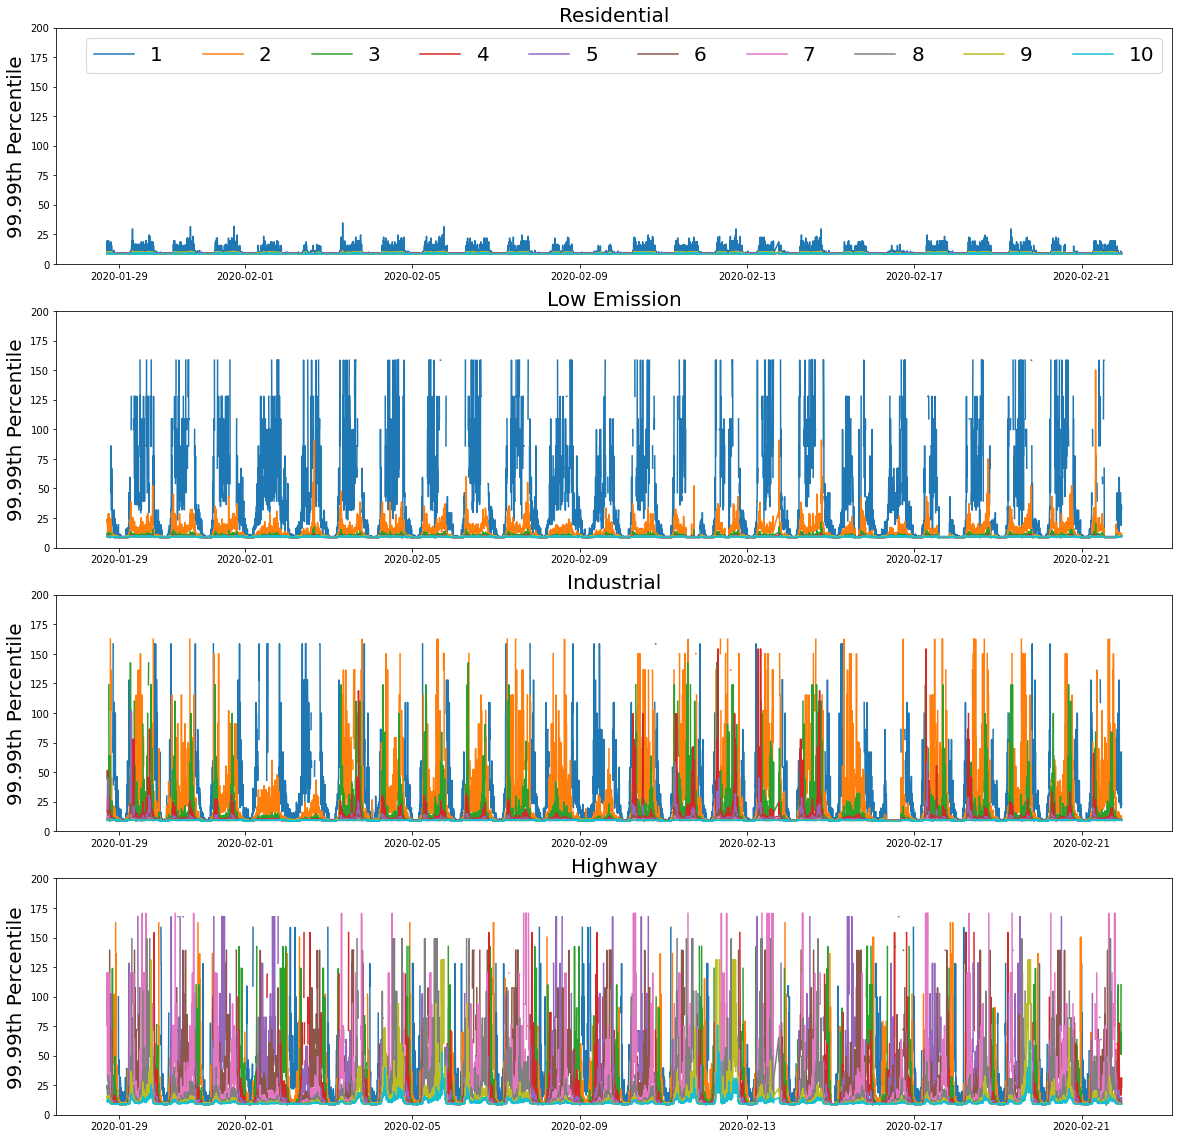

In [13]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} 99.99th'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} 99.99th'])
    axarr[2].plot(industrial_lambdas[f'R={R} 99.99th'])
    axarr[3].plot(highway_lambdas[f'R={R} 99.99th'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel('99.99th Percentile', fontsize=20)
axarr[1].set_ylabel('99.99th Percentile', fontsize=20)
axarr[2].set_ylabel('99.99th Percentile', fontsize=20)
axarr[3].set_ylabel('99.99th Percentile', fontsize=20)
axarr[0].set_ylim(0, 200)
axarr[1].set_ylim(0, 200)
axarr[2].set_ylim(0, 200)
axarr[3].set_ylim(0, 200)
axarr[0].legend(ncol=10, fontsize=20)

In [16]:
def get_prob_exceeding_target(lmbda, mu, R, target):
    """
    Obtains the probability of exceeding the target time for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    prob = 1 - cdf[cdf['sojourn_time'] >= target]['cdf'].min()
    return prob

In [17]:
for R in tqdm.tqdm_notebook(range(1, 11)):
    highway_lambdas[f'R={R} P(>10)'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    industrial_lambdas[f'R={R} P(>10)'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    lowemission_lambdas[f'R={R} P(>10)'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    residential_lambdas[f'R={R} P(>10)'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))

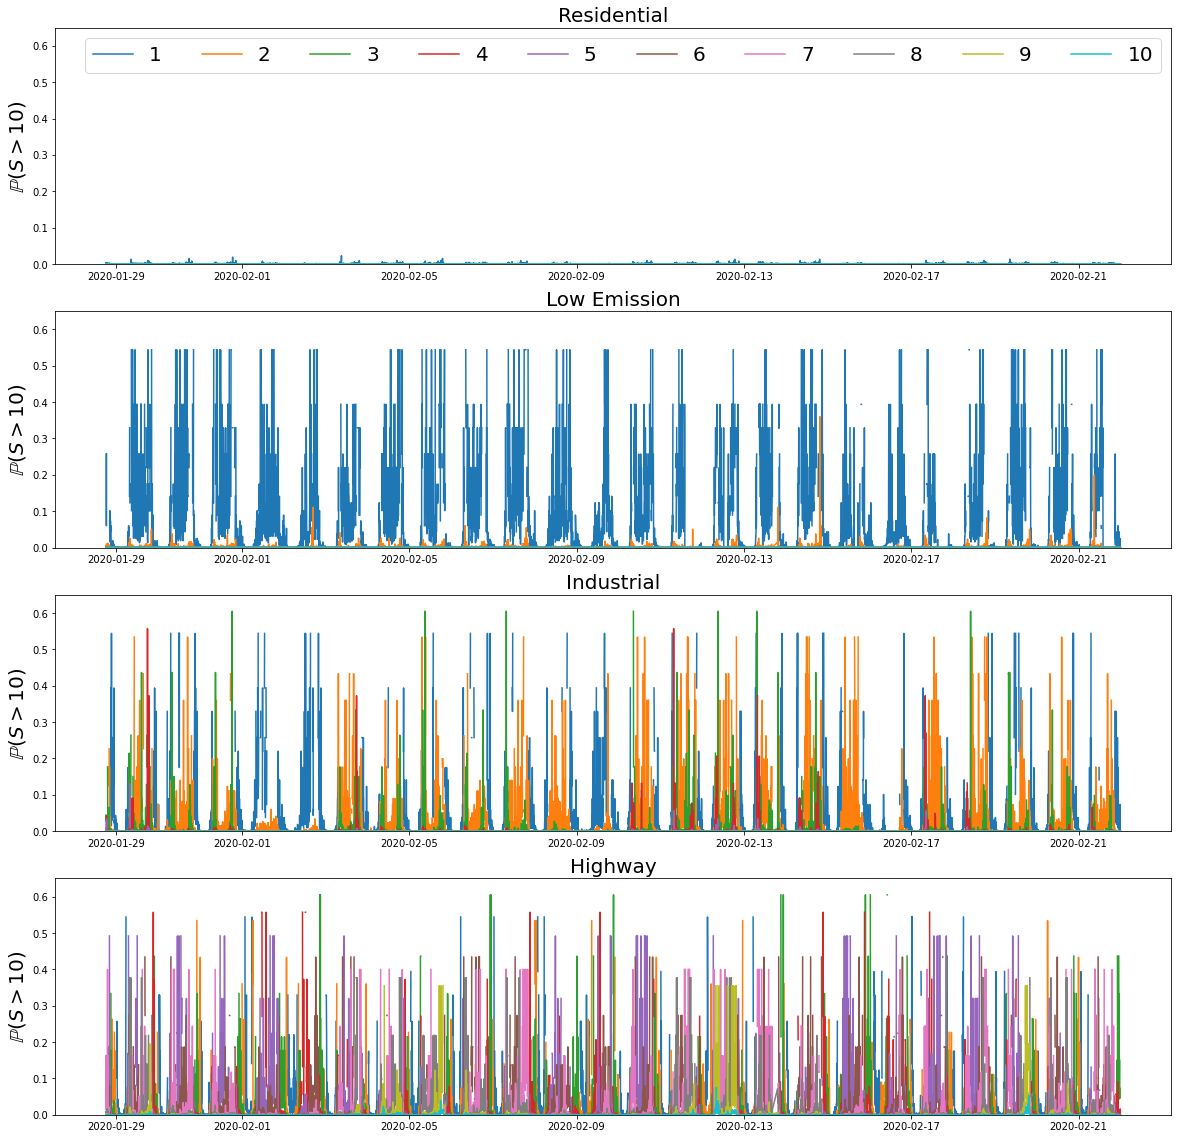

In [13]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} P(>10)'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} P(>10)'])
    axarr[2].plot(industrial_lambdas[f'R={R} P(>10)'])
    axarr[3].plot(highway_lambdas[f'R={R} P(>10)'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[1].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[2].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[3].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[0].set_ylim(0, 0.65)
axarr[1].set_ylim(0, 0.65)
axarr[2].set_ylim(0, 0.65)
axarr[3].set_ylim(0, 0.65)
axarr[0].legend(ncol=10, fontsize=20)

In [14]:
def get_min_R_above_target_prob(row, target_prob):
    ps = row[[f'R={R} P(>10)' for R in range(1, 11)]]
    satisfied_Rs = [R+1 if p < (1 - target_prob) else np.nan for R, p in enumerate(ps)]
    if all(np.isnan(satisfied_Rs)):
        return np.nan
    minR = np.nanmin(satisfied_Rs)
    return minR

In [15]:
highway_lambdas['Best R'] = highway_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
industrial_lambdas['Best R'] = industrial_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
lowemission_lambdas['Best R'] = lowemission_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
residential_lambdas['Best R'] = residential_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)

[]

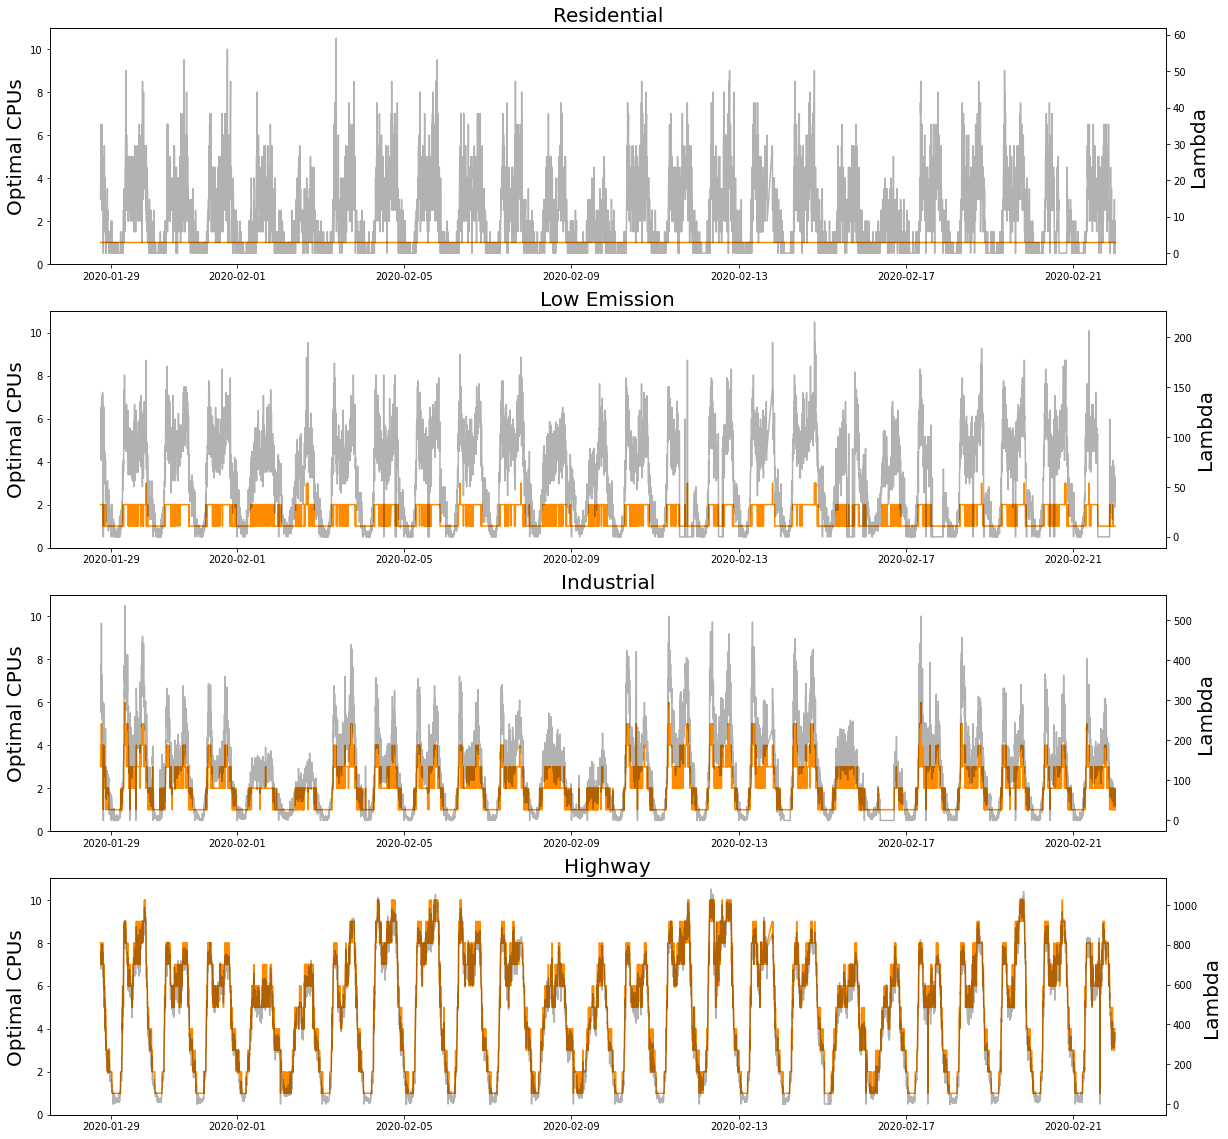

In [16]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
axarr2 = [axarr[i].twinx() for i in range(4)]
axarr2[0].plot(residential_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[1].plot(lowemission_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[2].plot(industrial_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[3].plot(highway_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[0].set_title('Residential', fontsize=20)
axarr2[1].set_title('Low Emission', fontsize=20)
axarr2[2].set_title('Industrial', fontsize=20)
axarr2[3].set_title('Highway', fontsize=20)
axarr[0].plot(residential_lambdas['Best R'], c='darkorange')
axarr[1].plot(lowemission_lambdas['Best R'], c='darkorange')
axarr[2].plot(industrial_lambdas['Best R'], c='darkorange')
axarr[3].plot(highway_lambdas['Best R'], c='darkorange')
for i in range(4):
    axarr[i].set_ylim(0, 11)
    axarr2[i].set_ylabel('Lambda', fontsize=20)
    axarr[i].set_ylabel('Optimal CPUs', fontsize=20)
plt.plot()

# Vehicular traffic vs. 99.99% latency

Text(0, 0.5, '99.99% latency [ms]')

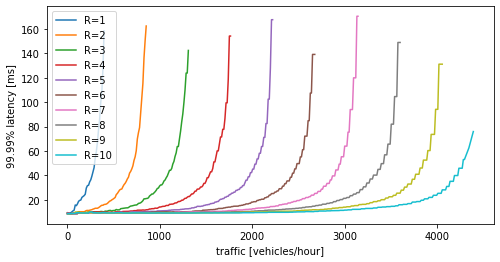

In [47]:
ax = plt.gca()

for R in range(1,11):
    highway_lambdas[['flow', f'R={R} 99.99th']].sort_values('flow').drop_duplicates().plot(x='flow', y=f'R={R} 99.99th', ax=ax, label=f'R={R}', figsize=(8,4))
plt.xlabel('traffic [vehicles/hour]')
plt.ylabel('99.99% latency [ms]')

# Peak hours propagation allowance

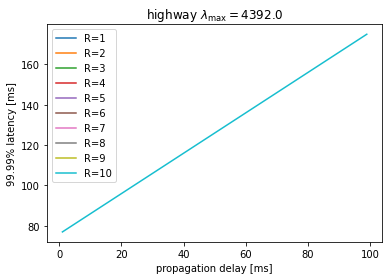

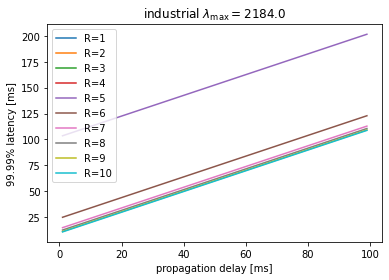

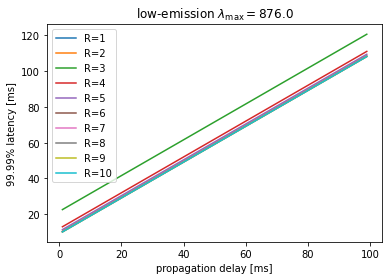

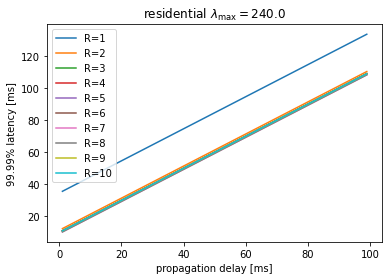

In [69]:
for road, label in [(highway_lambdas, 'highway'),
                    (industrial_lambdas, 'industrial'),
                    (lowemission_lambdas, 'low-emission'),
                    (residential_lambdas, 'residential')]:
    for R in range(1,11):
        flow, latency99 = road[['flow', f'R={R} 99.99th']].sort_values('flow').tail(1).values[0]
        plt.plot(range(1,100), [latency99 + i for i in range(1,100)], label=f'R={R}')
    plt.legend()
    plt.title(label + r' $\lambda_\max=$' + f'{flow}')
    plt.xlabel('propagation delay [ms]')
    plt.ylabel('99.99% latency [ms]')
    plt.show()

# Derive a smart scaling strategy

 1. at instant $t$ we have a given $\lambda$;
 2. we decrease $R$ from 10 down to 1; and
 2. we stop when $\tfrac{\lambda}{R\mu}$ 99.99% latency $>100$ms

In [11]:
def smart_scaling(lmbd, mu, tgt, p, cdf, data=None, nr_rtt=28.095):
    # lmbd: lambda
    # mu: mu
    # tgt: target sojourn time
    # p: percentile, e.g., 0.9999 (the 99.99% percentile)
    # cdf: the CDF function to use
    # data: (optional) 
    #   if data=None it is simulation CDF
    #   if data=DataFrame it is ['R','rho','best']
    # nr_rtt: RTT introduced in the new radio segment
    #         https://euprojects.netcom.it.uc3m.es/5g-dive/wp-content/uploads/2022/01/D3.3_Final.pdf
    #         Table 5.2 max downlink ping for 5G-SA wo/ URLLC
    #
    # returns: R: min R to get the p-percentile of delay <tgt
    #          delp: p-percentile delay
    #          method: None/{A,B,C,D,E,F}
    
    # Turn off CPUs when there is no demand
    if lmbd==0:
        return 0, 0, None
    
    # Substract the worst NR RTT -> computing tgt delay
    comp_tgt = tgt - nr_rtt
    
    # Scale #CPUs up to 10 until we meet tgt delay
    delp = comp_tgt+1
    R = 0
    while R<10 and delp>comp_tgt:
        R += 1
        rho = lmbd/(R*mu)
        if rho<1:
            delp = get_percentiles(lmbd, mu, R, p, cdf)
            delp = comp_tgt+1 if np.isnan(delp) else delp
        
    # Get the medhod? used by the approx.
    rho_r = round(lmbd/(R*mu), 2)
    method_idx = None
    if isinstance(data, pd.DataFrame):
        #print(delp, lmbd, mu,R,rho_r, rho)
        #print(data[(data['R']==R) & (data['rho']==rho_r)])
        method_idx = data[(data['R']==R) & (data['rho']==rho_r)]['best'].values[0]
    
    return R, delp, method_idx

In [12]:
off = 100
period = 288*7
res = highway_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 100, 0.9999, cdfs, data=data))

In [13]:
highway_lambdas['lambda_v2x'][off:period+off][2]

20.65

/home/netcom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


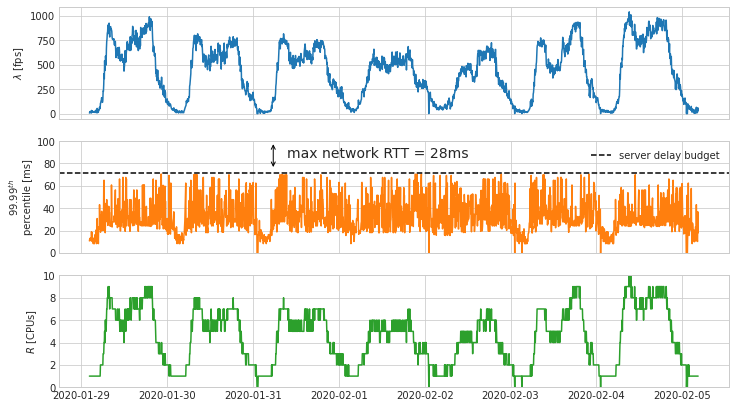

In [88]:
import itertools
import seaborn as sns

# method colors
cols = ['gold', 'firebrick', 'forestgreen', 'royalblue', 'darkorchid', 'darkturquoise']

Rs = [res[i][0] for i in range(len(res))]
delps = [res[i][1] for i in range(len(res))]
rhos = [highway_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]
#method_idxs = np.array([res[i][2] for i in range(len(res))])

#print(np.unique(method_idxs))


palette = itertools.cycle(sns.color_palette())


##x = range(len(Rs))
x = highway_lambdas['lambda_v2x'][off:period+off].index

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7))


c = next(palette)
axs[0].plot(x, highway_lambdas['lambda_v2x'][off:period+off], color=c)
axs[0].set_ylabel(r'$\lambda$ [fps]')

c = next(palette)
axs[1].plot(x, delps, color=c)
axs[1].set_ylabel(r'$99.99^{th}$' + "\npercentile [ms]")
axs[1].axhline(100-28.095, ls='dashed', color='black', label='server delay budget')
axs[1].annotate('max network RTT = 28ms',  horizontalalignment='left',
                xy=(.34,.8),  xycoords='axes fraction',
                xytext=(0.34,.85), textcoords='axes fraction',
                fontsize=14)
axs[1].annotate("",
            xy=(0.32, 0.75), xycoords='axes fraction',
            xytext=(0.32, 0.99), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )
axs[1].legend()
axs[1].set_ylim(0,100)

c = next(palette)
axs[2].plot(x, Rs, color=c)
axs[2].set_ylabel(r'$R$ [CPUs]')
axs[2].set_ylim(0,10)

plt.savefig(f'/tmp/scale-snapshot.pdf', transparent=True, bbox_inches='tight')

#for idx in range(1,len(cols)+1):
#    if idx in method_idxs:
#        axs[3].fill_between(x, 0,1000, color=cols[idx-1], where=method_idxs==idx,
#                        label='ABCDEF'[idx-1])
#axs[3].set_ylim(0,1)    
#axs[3].set_yticks([])
#axs[3].legend(ncol=4)


# TODO: add space,use timestamps, add grid

In [42]:
rho = 0.9

1/(1-rho)/1

10.000000000000002

# Compare the scaling efficiency

Depending on whether service times are more similar to deterministic, or uniform; the CDF results will differ so as the number of CPUs.

In [15]:
# Load the results for industrial, residential, highway, low emissions

scenarios = {
    'industrial': {'lambdas': industrial_lambdas},
    'residential': {'lambdas': residential_lambdas},
    'highway': {'lambdas': highway_lambdas},
    'lowemission': {'lambdas': lowemission_lambdas},
}

In [16]:
# Compute the scaling results for each scenario, and every distribution

for sce in scenarios.keys():
    print(f'Scenario: {sce}')
    for dist, cdfs in tqdm.tqdm_notebook([('approx', cdfs), ('unif', unif_cdfs), ('det', det_cdfs), ('exp', exp_cdfs)]):
        data = None if dist!='approx' else data
        scenarios[sce][dist] = scenarios[sce]['lambdas']['lambda_v2x'].apply(
            lambda l: smart_scaling(l, mu, 100, 0.9999, cdfs, data=data))

Scenario: industrial



Scenario: residential



Scenario: highway



Scenario: lowemission


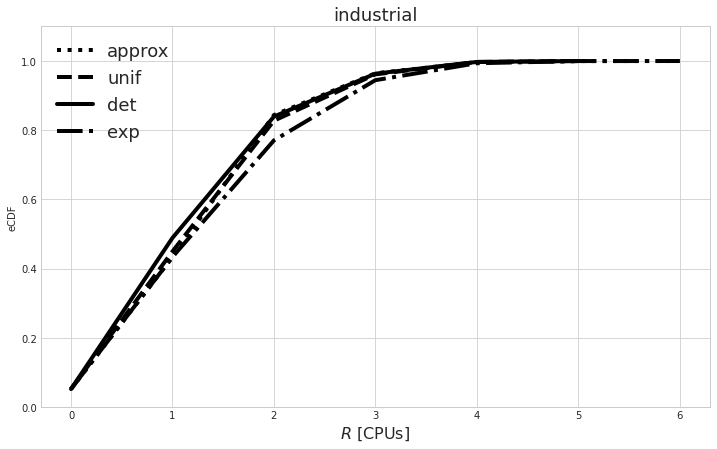

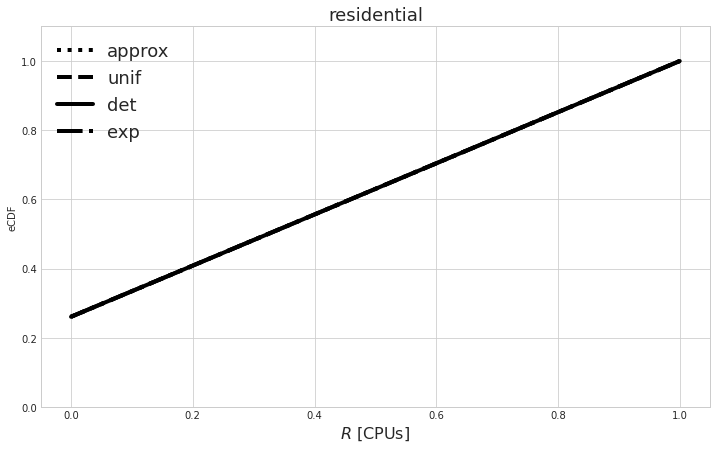

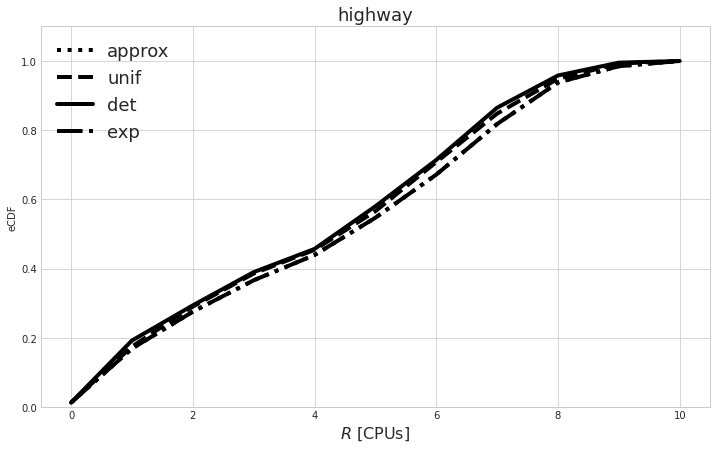

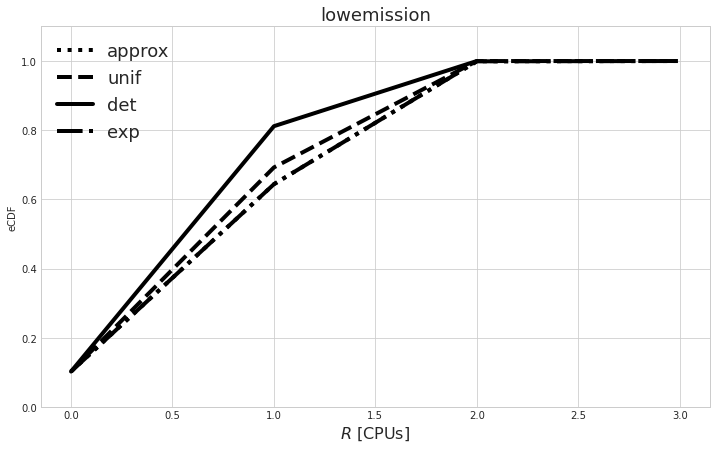

In [17]:
# Compare the number of CPUs required by every distribution

import matplotlib as mpl


lss = {
    'approx': 'dotted',
    'unif': 'dashed',
    'det': 'solid',
    'exp': 'dashdot'
}

markers = {
    'approx': (4,0,45),
    'unif': (2,0,0),
    'det': (4,2,45),
    'dashdot': (4,0,0),
}

#plt.gca().set_aspect('equal')



num_lambds = len(scenarios['industrial']['lambdas'])

## Plot the eCDF for the #CPUs ##
for sce in scenarios.keys():
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    
    for dist in ['approx', 'unif', 'det', 'exp']:        
        R = [scenarios[sce][dist][i][0] for i in range(num_lambds)]
        # CDF - https://stackoverflow.com/a/30460089
        X2 = np.sort(R)
        F2 = np.array(range(len(R)))/float(len(R))
        X2_ = np.unique(X2)
        F2_ = [max(F2[X2==r]) for r in X2_]
        #
        ax.plot(X2_, F2_, label=dist, ls=lss[dist], color='black',
                 lw=4)
                 #marker=markers[dist], markerfacecolor='none',
                 #markersize=10, )
    plt.xlabel(r'$R$ [CPUs]', fontsize=16)
    plt.ylim(0,1.1)
    plt.ylabel('eCDF')
    plt.legend(fontsize=18)
    plt.title(sce, fontsize=18)
    plt.savefig(f'/tmp/cpus-cdf-{sce}.pdf', transparent=True, bbox_inches='tight')
    plt.show()
    
    

# Compare the 99.99-percentile delays

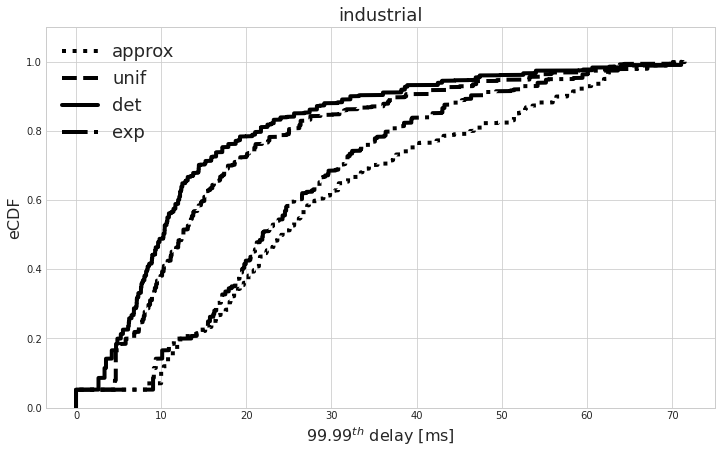

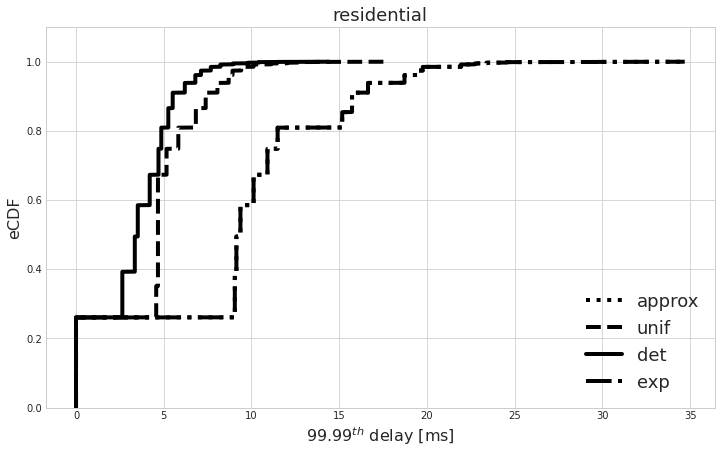

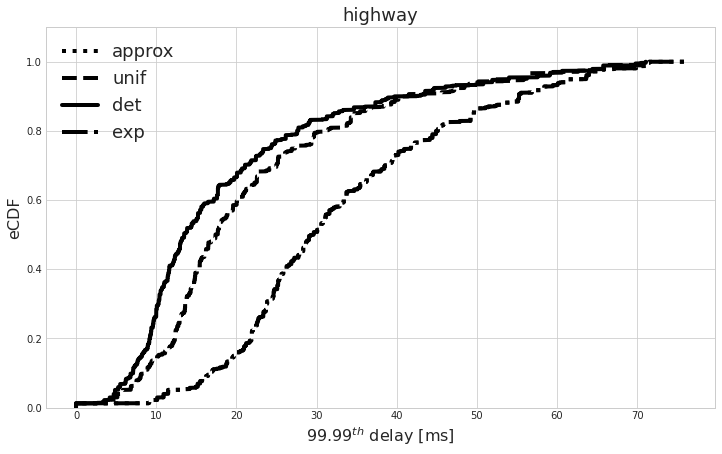

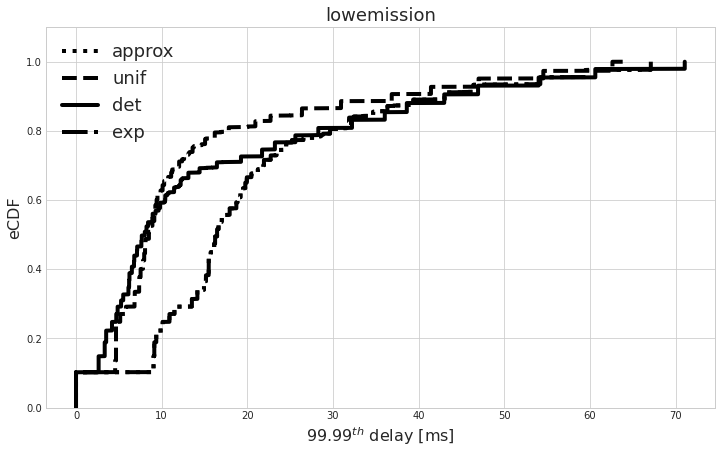

In [18]:

## Plot the eCDF for the 99.99-percentile delay ##
for sce in scenarios.keys():
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    
    for dist in ['approx', 'unif', 'det', 'exp']:        
        d = [scenarios[sce][dist][i][1] for i in range(num_lambds)]
        # CDF - https://stackoverflow.com/a/30460089
        X2 = np.sort(d)
        F2 = np.array(range(len(d)))/float(len(d))
        #
        #fig = plt.figure(figsize=(12, 7))
        ax.plot(X2, F2, label=dist, ls=lss[dist], color='black',
                 lw=4)
                 #marker=markers[dist], markerfacecolor='none',
                 #markersize=5, markevery=300)
    plt.xlabel(r'$99.99^{th}$ delay [ms]', fontsize=16)
    plt.ylabel('eCDF', fontsize=16)
    plt.ylim(0,1.1)
    plt.legend(fontsize=18)
    plt.title(sce, fontsize=18)
    plt.savefig(f'/tmp/delays-cdf-{sce}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

# Compare the CPU differences

In [19]:
a, b =enumerate(['A','N'])

print(a,b)

(0, 'A') (1, 'N')


In [20]:
# Compute scaling differences

dRs_dict = {}
for i, sce in enumerate(scenarios.keys()):
    for j, dist in enumerate(['exp', 'unif', 'det']):
        dRs_dict[sce,dist] = [scenarios[sce]['approx'][i][0] -\
              scenarios[sce][dist][i][0]\
              for i in range(num_lambds)]

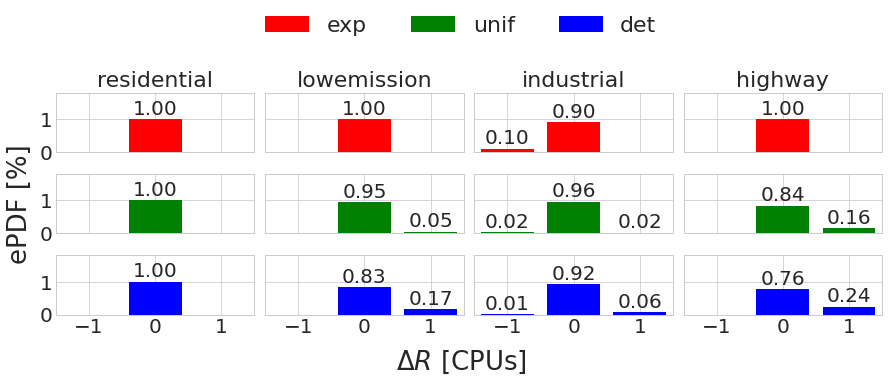

In [86]:
dist_cols = {
    'exp': 'red',
    'unif': 'green',
    'det': 'blue'
}

fig, axs = plt.subplots(3,4, figsize=(12,4), sharex=True, sharey=True, tight_layout=True)
for i, dist in enumerate(['exp', 'unif', 'det']):
    for j, sce in enumerate(['residential', 'lowemission', 'industrial', 'highway']):
    

        dRs = dRs_dict[sce,dist]
        labels, counts = np.unique(dRs, return_counts=True)
        label = f'{dist}' if j == 0 else None
        bars = axs[i][j].bar(labels, counts/len(dRs), align='center',
                     label=label, color=dist_cols[dist])
        for rect in bars:
            height = rect.get_height()
            axs[i][j].text(rect.get_x() + rect.get_width()/2.0,
                     height+.02, '{:.2f}'.format(height), ha='center', va='bottom',
                     rotation=0, fontsize=20) 
            if i==0:
                axs[i][j].set_title(sce, fontsize=22)

        axs[i][j].set_xlim(-1.5,1.5)
        axs[i][j].set_xticks([-1,0,1])
        #axs[i][j].set_xticlabels(fontsize=22)
        axs[i][j].set_ylim(0,1.8)
        axs[i][j].tick_params(labelsize=20)
        # plt.legend(fontsize=18)
        #plt.title(sce, fontsize=18)
        #axs[i][j].grid(False)


#plt.xlabel()
fig.text(0.5,-0.05, r'$\Delta R$ [CPUs]', fontsize=26, ha="center", va="center")
fig.text(-.01,0.5, "ePDF [%]", fontsize=26, ha="center", va="center",
        rotation=90)
fig.legend(loc='upper center', ncol=3, fontsize=22, bbox_to_anchor=(0., 1.12, 1., .102))


plt.savefig(f'/tmp/delta-R.pdf', transparent=True, bbox_inches='tight')
plt.show()